# Explore the Dataset

In [1]:
from collections import Counter
import sys
sys.path.append('..')
import utils.filtering as flt
import utils.feature_extraction as feat
from tqdm import tqdm

In [2]:
from utils.load_data import *
path = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\imu_compensatory_movements\Data\IMU Data"

In [3]:
data = load_all_subjects(path)

In [4]:
data

[{'subject': 'P02',
  'file': 'arm_l_P_02_02_anonymized.csv',
  'sensor': 'arm_l',
  'task': 'cup-placing',
  'condition': 'natural',
  'dataframe':       PacketCounter       SampleTimeFine    Quat_W    Quat_X    Quat_Y  \
  0                 0  1970-01-01 21:07:25 -0.736210  0.183717  0.638716   
  1                 1  1970-01-02 01:45:12 -0.736222  0.183720  0.638712   
  2                 2  1970-01-02 06:22:59 -0.736170  0.183847  0.638716   
  3                 3  1970-01-02 11:00:46 -0.736107  0.183970  0.638727   
  4                 4  1970-01-02 15:38:33 -0.736076  0.183974  0.638764   
  ...             ...                  ...       ...       ...       ...   
  3408           3408  1971-10-21 07:13:01 -0.719578  0.178472  0.651305   
  3409           3409  1971-10-21 11:50:48 -0.719438  0.178067  0.651667   
  3410           3410  1971-10-21 16:28:35 -0.719289  0.177722  0.652004   
  3411           3411  1971-10-21 21:06:22 -0.719175  0.177484  0.652258   
  3412           

IMU FILE numbers:  </br>
02 - cup-placing natural </br>
03 - pouring natural  </br>
04 - peg natural  </br>
05 - wiping natural  </br>
06 - cup-placing elbow brace  </br>
07 - pouring elbow brace  </br>
08 - peg elbow brace  </br>
09 - wiping elbow brace  </br>
10 - cup-placing elbow and wrist brace  </br>
11 - pouring elbow and wrist brace  </br>
12 - peg elbow and wrist brace  </br>
13 - wiping elbow and wrist brace  </br>



In [5]:
# We have 12 conditions
# 5 subjects
# In total, we expect 60 dataframes

# Important: data from arm_l, arm_r, trunk, wrist_l, wrist_r must be considered together! (5 IMU used, see slide 4)

In [6]:
# We need then to group the data from the 5 sensors to create one unique dataset per condition
# Check unique sensors
sensors = set([d['sensor'] for d in data])
print("Unique sensors:", sensors)
subject_counts = Counter([d['subject'] for d in data])
print("Files per subject:", subject_counts) # note: we should have 60, some subjects have more recodings

# Check unique task codes
tasks_conditions = set([(d['task'], d['condition']) for d in data])
print("Unique task/condition combinations:", tasks_conditions)


Unique sensors: {'arm_l', 'wrist_l', 'trunk', 'arm_r', 'wrist_r'}
Files per subject: Counter({'P03': 65, 'P04': 65, 'P05': 65, 'P06': 65, 'P02': 64})
Unique task/condition combinations: {('peg', 'elbow_wrist_brace'), (None, None), ('pouring', 'natural'), ('cup-placing', 'natural'), ('peg', 'elbow_brace'), ('wiping', 'elbow_brace'), ('wiping', 'elbow_wrist_brace'), ('peg', 'natural'), ('wiping', 'natural'), ('pouring', 'elbow_wrist_brace'), ('pouring', 'elbow_brace'), ('cup-placing', 'elbow_wrist_brace'), ('cup-placing', 'elbow_brace')}


In [7]:
tasks = set(d['task'] for d in data)
print("Type of tasks:", tasks)

conditions = set([d['condition'] for d in data])
print("Conditions per task:", conditions)

# Note: we will skip the "None" 


Type of tasks: {None, 'cup-placing', 'peg', 'pouring', 'wiping'}
Conditions per task: {None, 'natural', 'elbow_wrist_brace', 'elbow_brace'}


In [8]:
from collections import Counter
import pandas as pd

def build_dataset(data, tasks, conditions, subject_ids=range(2, 7)):
    all_subjects = []

    for sub_id in subject_ids:
        subject_id = f"P0{sub_id}"
        subject_data = [d for d in data if d.get("subject") == subject_id]

        for curr_task in tasks:
            task_data = [t for t in subject_data if t.get("task") == curr_task]

            # Must be 15 entries = 5 sensors × 3 conditions
            if len(task_data) != 15:
                print("Len different than 15, task is:", curr_task)
                print("skipping...", [f['file'] for f in task_data])
                print()
                continue

            # Unique task name
            task_names = [t['task'] for t in task_data]
            task_names = [item for item, count in Counter(task_names).items() if count > 1]
            if len(task_names) != 1:
                continue
            task_name = task_names[0]

            for curr_condition in conditions:
                df_raw = pd.DataFrame()
                condition_data = [c for c in task_data if c.get("condition") == curr_condition]

                # Unique condition
                condition_names = [c['condition'] for c in condition_data]
                condition_names = [item for item, count in Counter(condition_names).items() if count > 1]
                if len(condition_names) != 1:
                    continue
                condition_name = condition_names[0]

                # --- extract and align sensors ---
                dfs_sensors = [df['dataframe'] for df in condition_data]
                sensor_names = [df['sensor'] for df in condition_data]

                lengths = [len(df) for df in dfs_sensors]
                min_len = min(lengths)

                for curr_df, sensor_name in zip(dfs_sensors, sensor_names):
                    ts = pd.to_datetime(curr_df["SampleTimeFine"])
                    dt_s = ts.diff().dt.total_seconds()

                    if dt_s.dropna().nunique() != 1:
                        print(f"[{subject_id} | {task_name} | {condition_name} | {sensor_name}] Non-constant dt!")

                    if curr_df["PacketCounter"].diff().dropna().nunique() != 1:
                        print(f"[{subject_id} | {task_name} | {condition_name} | {sensor_name}] Packet counter not consecutive!")

                    sensor_data = curr_df.iloc[:min_len].copy()
                    sensor_data = sensor_data[curr_df.columns[2:]]   # drop time + counter
                    sensor_data = sensor_data.add_suffix(f"_{sensor_name}")

                    df_raw = pd.concat([df_raw, sensor_data], axis=1)

                # Add metadata columns
                df_raw["subject"] = subject_id
                df_raw["task"] = task_name
                df_raw["condition"] = condition_name

                print(f"Done with subject {subject_id}, task {task_name}, condition {condition_name}")

                all_subjects.append({
                    "subject": subject_id,
                    "task": task_name,
                    "condition": condition_name,
                    "data": df_raw
                })

        print(f"Done with subject {subject_id}...\n")

    return all_subjects


In [9]:
all_subjects = build_dataset(data, tasks, conditions)


Len different than 15, task is: None
skipping... ['arm_r_P_02_01_anonymized.csv', 'trunk_P_02_01_anonymized.csv', 'wrist_l_P_02_01_anonymized.csv', 'wrist_r_P_02_01_anonymized.csv']

Done with subject P02, task cup-placing, condition natural
Done with subject P02, task cup-placing, condition elbow_wrist_brace
Done with subject P02, task cup-placing, condition elbow_brace
Done with subject P02, task peg, condition natural
Done with subject P02, task peg, condition elbow_wrist_brace
Done with subject P02, task peg, condition elbow_brace
Done with subject P02, task pouring, condition natural
Done with subject P02, task pouring, condition elbow_wrist_brace
Done with subject P02, task pouring, condition elbow_brace
Done with subject P02, task wiping, condition natural
Done with subject P02, task wiping, condition elbow_wrist_brace
Done with subject P02, task wiping, condition elbow_brace
Done with subject P02...

Len different than 15, task is: None
skipping... ['arm_l_P_03_01_anonymized.cs

In [10]:
dataset = {}
for entry in all_subjects:
    s = entry["subject"]
    t = entry["task"]
    c = entry["condition"]
    df = entry["data"]

    dataset.setdefault(s, {}).setdefault(t, {})[c] = df



# Data Visualizations

In [11]:
from utils.filtering import filter_butterworth

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_imus_5x3(df_raw, sensor_names, base_signals=None, fs=60, title=None):
    """
    df_raw:      dataframe with columns like 'AccX_IMU1', 'AccY_IMU1', ...
    sensor_names: list of 5 sensor names, e.g. ['IMU1', 'IMU2', ...]
    base_signals: list of base names to plot per IMU, e.g. ['AccX', 'AccY', 'AccZ']
    fs:          sampling frequency (for time axis), default 60 Hz
    """
    if base_signals is None:
        base_signals = ['Acc_X', 'Acc_Y', 'Acc_Z']   # 3 signals per IMU

    n_sensors = len(sensor_names)
    n_signals = len(base_signals)

    # time axis (if you don't have time column)
    n_samples = len(df_raw)
    t = np.arange(n_samples) / fs

    fig, axes = plt.subplots(
        nrows=n_sensors,
        ncols=n_signals,
        figsize=(4 * n_signals, 2.5 * n_sensors),
        sharex=True
    )

    # If only one sensor or one signal, axes might not be 2D
    if n_sensors == 1:
        axes = np.expand_dims(axes, axis=0)
    if n_signals == 1:
        axes = np.expand_dims(axes, axis=1)

    for i, sensor_name in enumerate(sensor_names):
        for j, base in enumerate(base_signals):
            ax = axes[i, j]

            col_name = f"{base}_{sensor_name}"
            if col_name not in df_raw.columns:
                ax.text(0.5, 0.5, f"{col_name}\nnot found", ha='center', va='center')
                ax.set_axis_off()
                continue

            y = df_raw[col_name].values
            ax.plot(t, y)

            # Titles / labels
            if i == 0:
                ax.set_title(base)          # AccX / AccY / AccZ on top row
            if j == 0:
                ax.set_ylabel(sensor_name)  # IMU name on left column

            if i == n_sensors - 1:
                ax.set_xlabel("Time [s]")
    if title:
        plt.suptitle(title)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [13]:
# Now, we can access the dataset using just the subject ID, task name, condition name
import numpy as np
len(dataset['P02'])  # 4 conditions
len(dataset['P02']['cup-placing'])      # 3 conditions


3

In [14]:
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def hampel_filter(series, window_size=7, n_sigmas=3):
    # window_size odd
    new_series = series.copy()
    k = 1.4826  # scale factor for Gaussian distribution
    L = n_sigmas
    n = (window_size - 1) // 2
    for i in range(len(series)):
        start = max(0, i - n)
        end = min(len(series), i + n + 1)
        window = series[start:end]
        med = np.nanmedian(window)
        mad = k * np.nanmedian(np.abs(window - med))
        if mad == 0:
            continue
        if abs(series[i] - med) > L * mad:
            new_series[i] = med
    return new_series
def apply_butter_filtfilt_df(df, cols, fs=60.0, cutoff=6.0, order=4):
    """
    Zero-phase Butterworth filter on specified columns.
    cutoff: Hz (6.0 is a reasonable default for human motion sampled at 60Hz)
    """
    df = df.copy()
    b, a = butter_lowpass(cutoff, fs, order=order)
    for c in cols:
        arr = df[c].to_numpy(dtype=float)
        # if short signals, filtfilt may fail; ensure len > 3*max(len(a), len(b))
        if len(arr) < (3 * max(len(a), len(b))):
            df[c] = arr  # skip filtering if too short
        else:
            df[c] = filtfilt(b, a, arr, method='pad')
    return df

In [15]:
def filter_butterworth(
    df,
    fs=60,
    cutoff=6.0,
    sensor_names=('arm_l', 'arm_r', 'trunk', 'wrist_l', 'wrist_r'),
    exclude_mag=True,
    ):
    """
    Hampel despike -> Butterworth lowpass
    applied to *all* sensors in a wide df with suffixed columns, e.g.:

        Acc_X_arm_l, Acc_Y_arm_l, ..., Gyr_Z_arm_l,
        Acc_X_arm_r, ..., Gyr_Z_arm_r, ...

    Parameters
    ----------
    df : pd.DataFrame
        Wide dataframe containing all sensors.
    fs : float
        Sampling frequency in Hz.
    cutoff : float
        Low-pass cutoff frequency in Hz.
    sensor_names : iterable of str
        Names used as suffixes in the columns (e.g. 'arm_l', 'trunk', ...).
    exclude_mag : bool
        If False, also filter magnetometer data (columns containing 'Mag').
    """
    df_proc = df.copy()

    for sensor_name in sensor_names:
        # all columns for this sensor
        sensor_columns = df_proc.columns[df_proc.columns.str.endswith(f"_{sensor_name}")]

        # group by type
        quaternion_columns = sensor_columns[sensor_columns.str.contains("Quat")]
        acc_columns        = sensor_columns[sensor_columns.str.contains("Acc")]
        gyr_columns        = sensor_columns[sensor_columns.str.contains("Gyr")]
        mag_columns        = sensor_columns[sensor_columns.str.contains("Mag")] if not exclude_mag else []

        # we usually filter only raw sensor signals (Acc, Gyr, Mag)
        cols_to_consider = list(acc_columns) + list(gyr_columns) + list(mag_columns)

        # nothing to do for this sensor
        if not cols_to_consider:
            continue

        # 1) Hampel despike
        for c in cols_to_consider:
            df_proc[c] = hampel_filter(
                df_proc[c].to_numpy(),
                window_size=7,
                n_sigmas=3,
            )

        # 2) Butterworth lowpass
        df_proc = apply_butter_filtfilt_df(
            df_proc,
            cols_to_consider,
            fs=fs,
            cutoff=cutoff,
            order=4,
        )

        # --- optional: quaternion renorm + Euler could go here,
        # using `quaternion_columns` if you want to handle them per sensor ---

    return df_proc


In [16]:
import numpy as np

def jerk_axis(df, sensor_name, axis="X", fs=60):
    """
    Compute jerk for one axis of one IMU.
    axis: 'X', 'Y', or 'Z'
    Returns an array of same length as input (pads first sample with 0).
    """
    col = f"Acc_{axis}_{sensor_name}"
    acc = df[col].to_numpy()

    # discrete derivative (causal, uses past)
    j = np.diff(acc) #* fs -> optionally to match physical units
    j = np.concatenate([[0.0], j])  # pad to same length as acc

    return j


In [17]:
def detect_movement_from_jerk(
    jerk,
    fs=60,
    win_ms=500,
    hop_ms=50,
    baseline_samples=300,
    k_on=3.0,
    k_off=1.5,
    n_consecutive_on=5,
    n_consecutive_off=3,
    ):
    """
    Windowed, causal detector on |jerk|.

    jerk : 1D array
        Jerk signal for one axis.
    """
    jerk = np.asarray(jerk)
    n = len(jerk)
    if n == 0:
        return [], (None, None, None, None)

    # Take positive values
    activity = np.abs(jerk)

    # --- baseline from first baseline_samples (rest) ---
    baseline_samples = min(baseline_samples, n)
    baseline = activity[:baseline_samples]
    mu = baseline.mean()
    sigma = baseline.std() if baseline.std() > 0 else 1e-6

    thr_on  = mu + k_on  * sigma
    thr_off = mu + k_off * sigma

    win_len = max(1, int(round(win_ms * fs / 1000.0)))
    hop     = max(1, int(round(hop_ms * fs / 1000.0)))

    moving = False
    start_idx = None
    epochs = []

    on_count  = 0
    off_count = 0
    first_on_start = None

    # start detection after baseline and after we have a full window
    start_search_sample = max(baseline_samples, win_len)
    end = start_search_sample - 1

    while end < n:
        start = end - win_len + 1
        win_mean = activity[start:end + 1].mean()

        if not moving:
            if win_mean > thr_on:
                if on_count == 0:
                    first_on_start = start
                on_count += 1
                if on_count >= n_consecutive_on:
                    moving = True
                    start_idx = first_on_start
                    off_count = 0
            else:
                on_count = 0
                first_on_start = None
        else:
            if win_mean < thr_off:
                off_count += 1
                if off_count >= n_consecutive_off:
                    end_idx = end
                    if end_idx > start_idx:
                        epochs.append((start_idx, end_idx))
                    moving = False
                    on_count = 0
                    first_on_start = None
            else:
                off_count = 0

        end += hop

    if moving and start_idx is not None:
        end_idx = n - 1
        if end_idx > start_idx:
            epochs.append((start_idx, end_idx))

    return np.array(epochs), (thr_on, thr_off, mu, sigma)


In [ ]:
def detect_movement_start_from_jerk(
    jerk,
    fs=60,
    win_ms=500,
    hop_ms=50,
    baseline_samples=300,
    k_on=4.0,
    n_consecutive_on=5,
    return_threshold = False, 
    ):
    """
    Windowed, causal detector on |jerk|.

    jerk : 1D array
        Jerk signal for one axis.
    """
    jerk = np.asarray(jerk)
    n = len(jerk)
    if n == 0:
        return [], (None, None, None, None)

    # Take positive values
    activity = np.abs(jerk)

    # --- baseline from first baseline_samples (rest) ---
    baseline_samples = min(baseline_samples, n)
    baseline = activity[:baseline_samples]
    mu = baseline.mean()
    sigma = baseline.std() if baseline.std() > 0 else 1e-6

    thr_on  = mu + k_on  * sigma

    win_len = max(1, int(round(win_ms * fs / 1000.0)))
    hop     = max(1, int(round(hop_ms * fs / 1000.0)))

    moving = False
    start_idx = None
    epochs = []

    on_count  = 0
    off_count = 0
    first_on_start = None

    # start detection after baseline and after we have a full window
    start_search_sample = max(baseline_samples, win_len)
    end = start_search_sample - 1
    found = False
    while (end < n) and (found == False):
        start = end - win_len + 1
        win_mean = activity[start:end + 1].mean()

        if not moving:
            if win_mean > thr_on:
                if on_count == 0:
                    first_on_start = start
                on_count += 1
                if on_count >= n_consecutive_on:
                    moving = True
                    found = True
                    start_idx = first_on_start
                    off_count = 0
            else:
                on_count = 0
                first_on_start = None

        end += hop

            
    if first_on_start == None:
        print("reached end without data found")
        first_on_start = np.nan
    if return_threshold:
        return first_on_start, thr_on
    return first_on_start


In [30]:
sensor_names=['arm_l', 'arm_r', 'trunk', 'wrist_l', 'wrist_r']

In [31]:
# Inspect some data
sub_id = 'P05'
task_name = 'wiping'
condition = 'elbow_wrist_brace' 
df_raw = dataset[sub_id][task_name][condition]

In [32]:
# NOTE: apply "hard" LP filter.
# To detect the start, we care only about "gross" movements (no high frequency oscillations)
df_filt = filter_butterworth(df_raw, fs=60, cutoff=2)

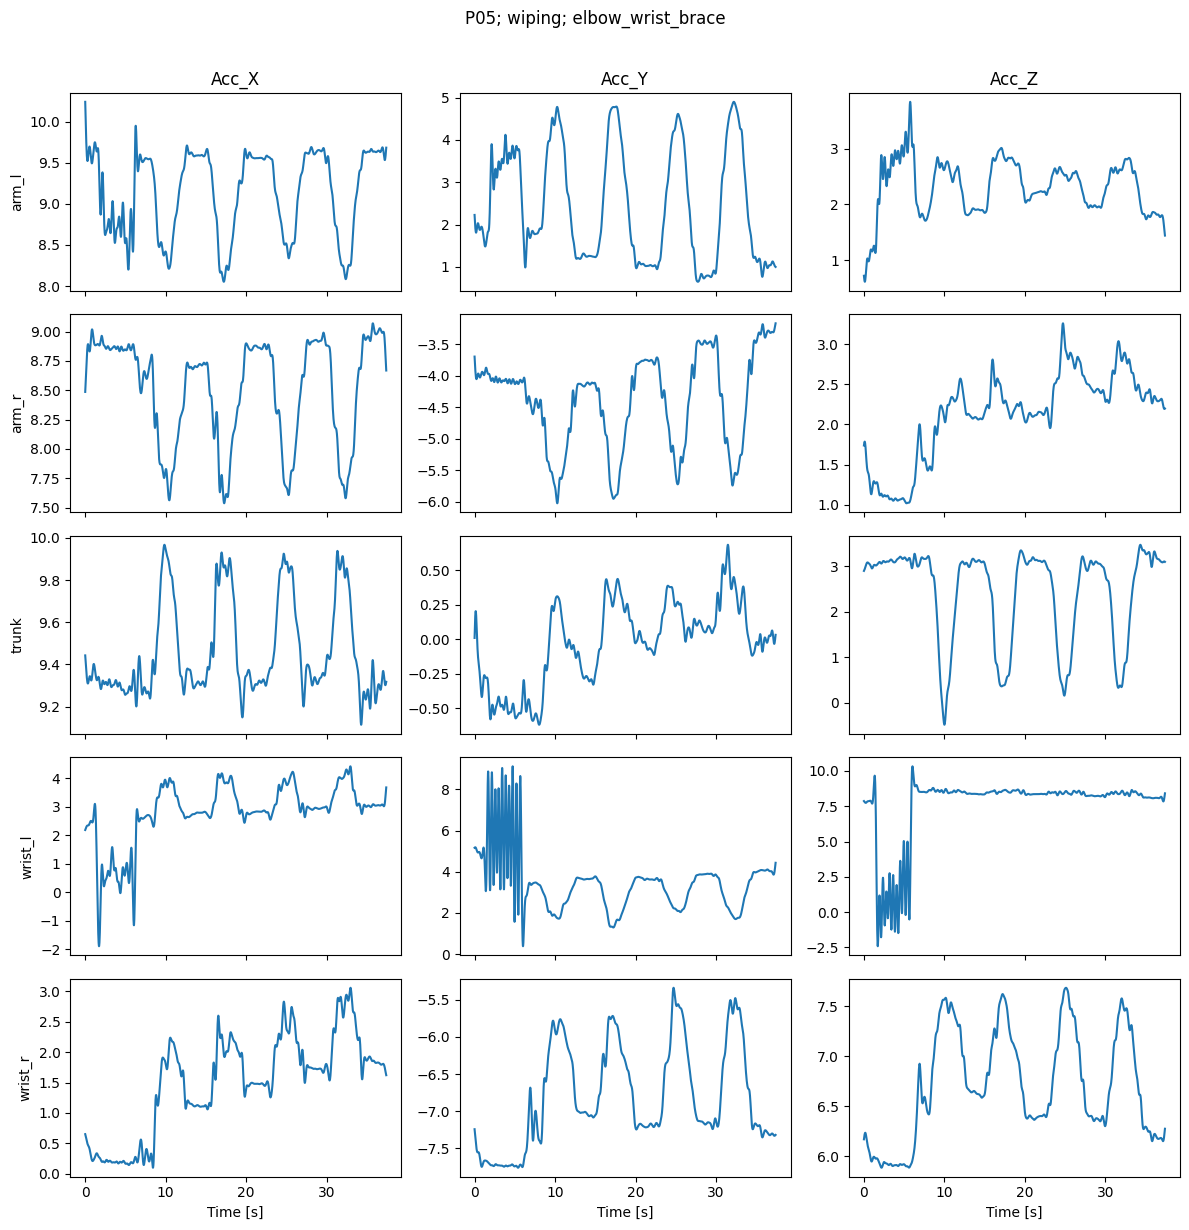

In [33]:
plot_imus_5x3(df_filt, sensor_names, title= f"{sub_id}; {task_name}; {condition}")

# Detect start of the movement

From the plots above and the description of the experimental protocol, we can observe that the "right wrist" might be a good candidate to determine the onset of the movement. </br>

All subjects were executing the task using the right arm.

In [34]:
sens_name = 'wrist_r'

In [35]:
jx = jerk_axis(df_filt, sens_name, "X", fs=60)
jy = jerk_axis(df_filt, sens_name, "Y", fs=60)
jz = jerk_axis(df_filt, sens_name, "Z", fs=60)

In [36]:
# jx_start = detect_movement_from_jerk(jx)
# jy_start = detect_movement_from_jerk(jy)
# jz_start = detect_movement_from_jerk(jz)

# Note: we care only about the very first start -> we can use the more simple function
jx_st, thr_x = detect_movement_start_from_jerk(jx, baseline_samples=240,return_threshold=True)
jy_st, thr_y = detect_movement_start_from_jerk(jy, baseline_samples=240, return_threshold=True)
jz_st, thr_z = detect_movement_start_from_jerk(jz,  baseline_samples=240, return_threshold=True)

# Note: there might be some cases when we don't detect start and stop from wrist
if np.isnan(jx_st) and np.isnan(jy_st) and np.isnan(jz_st):
    # Enter here only for few condtions
    sens_name = 'wrist_l'
    jx = jerk_axis(df_filt, sens_name, "X", fs=60)
    jy = jerk_axis(df_filt, sens_name, "Y", fs=60)
    jz = jerk_axis(df_filt, sens_name, "Z", fs=60)
    jx_st, thr_x = detect_movement_start_from_jerk(jx, baseline_samples=240, return_threshold=True)
    jy_st, thr_x = detect_movement_start_from_jerk(jy, baseline_samples=240, return_threshold=True)
    jz_st, thr_z= detect_movement_start_from_jerk(jz,  baseline_samples=240, return_threshold=True)


# to make it easy, take the mean of the three
mean_start_loc = int(np.nanmean([jx_st, jy_st, jz_st]))



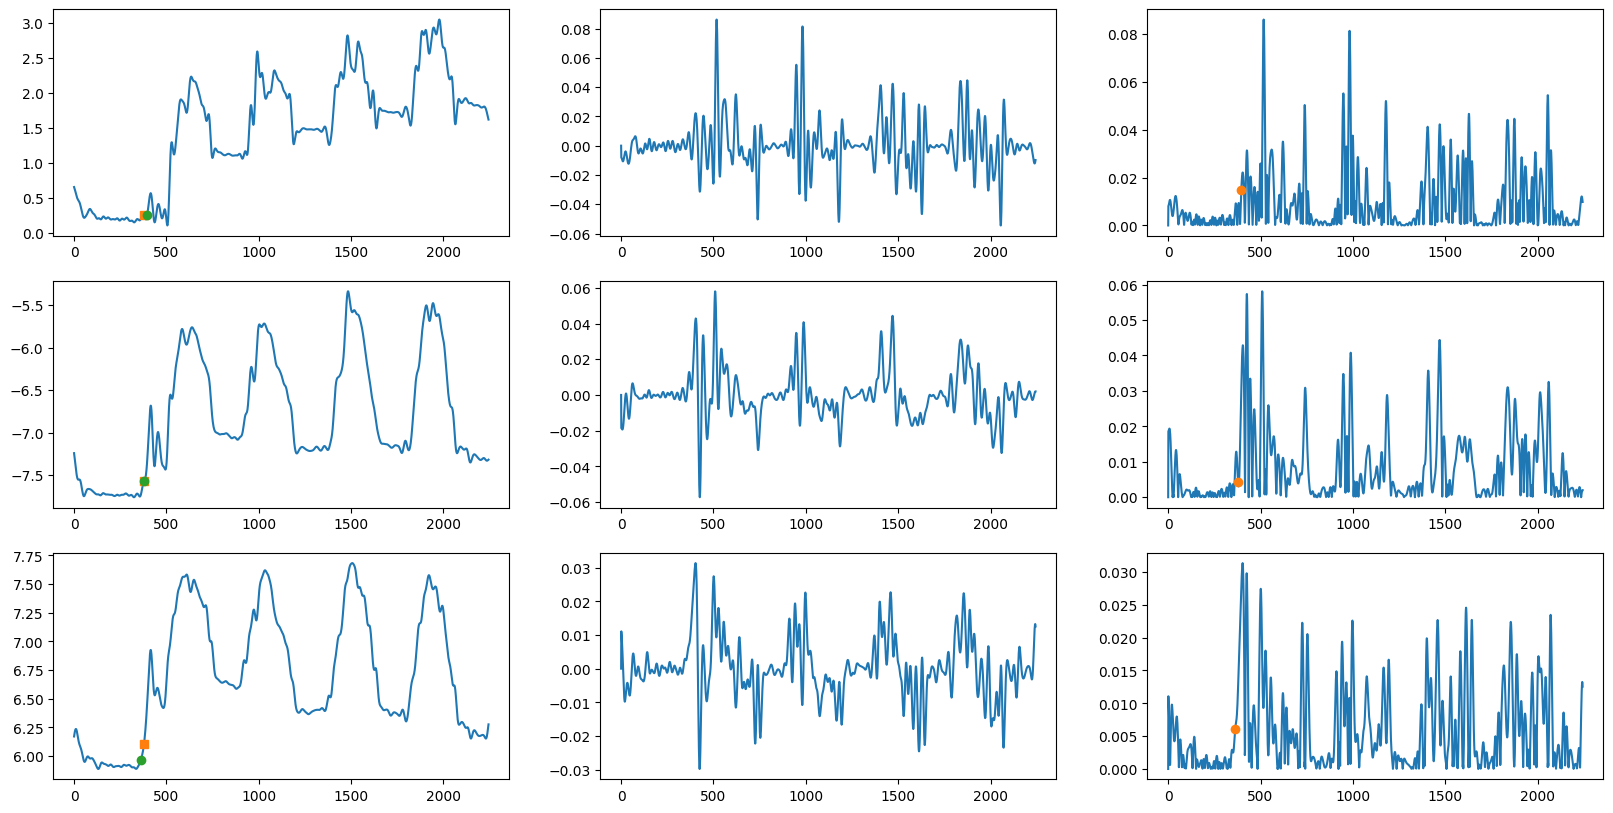

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(20,10))

axs[0,0].plot(df_filt[f'Acc_X_{sens_name}'])
axs[0,1].plot(jx)
axs[0,2].plot(np.abs(jx))
axs[0,0].plot(mean_start_loc, np.array(df_filt[f'Acc_X_{sens_name}'])[mean_start_loc], marker='s')
if np.isnan(jx_st) == False:
    axs[0,0].plot(jx_st, np.array(df_filt[f'Acc_X_{sens_name}'])[jx_st], marker='o', linestyle='')
    axs[0,2].plot(jx_st, np.abs(jx)[jx_st], marker='o', linestyle='')


axs[1, 0].plot(df_filt[f'Acc_Y_{sens_name}'])

axs[1, 1].plot(jy)
axs[1, 2].plot(np.abs(jy))
axs[1, 0].plot(mean_start_loc, np.array(df_filt[f'Acc_Y_{sens_name}'])[mean_start_loc], marker='s')
if np.isnan(jy_st) == False:
    axs[1, 0].plot(jy_st, np.array(df_filt[f'Acc_Y_{sens_name}'])[jy_st], marker='o', linestyle='')
    axs[1, 2].plot(jy_st, np.abs(jy)[jy_st], marker='o', linestyle='')

axs[2, 0].plot(df_filt[f'Acc_Z_{sens_name}'])

axs[2, 1].plot(jz)
axs[2, 2].plot(np.abs(jz))
axs[2, 0].plot(mean_start_loc, np.array(df_filt[f'Acc_Z_{sens_name}'])[mean_start_loc], marker='s')
if np.isnan(jz_st) == False:
    axs[2, 0].plot(jz_st, np.array(df_filt[f'Acc_Z_{sens_name}'])[jz_st], marker='o', linestyle='') 
    axs[2, 2].plot(jz_st, np.abs(jz)[jz_st], marker='o', linestyle='')

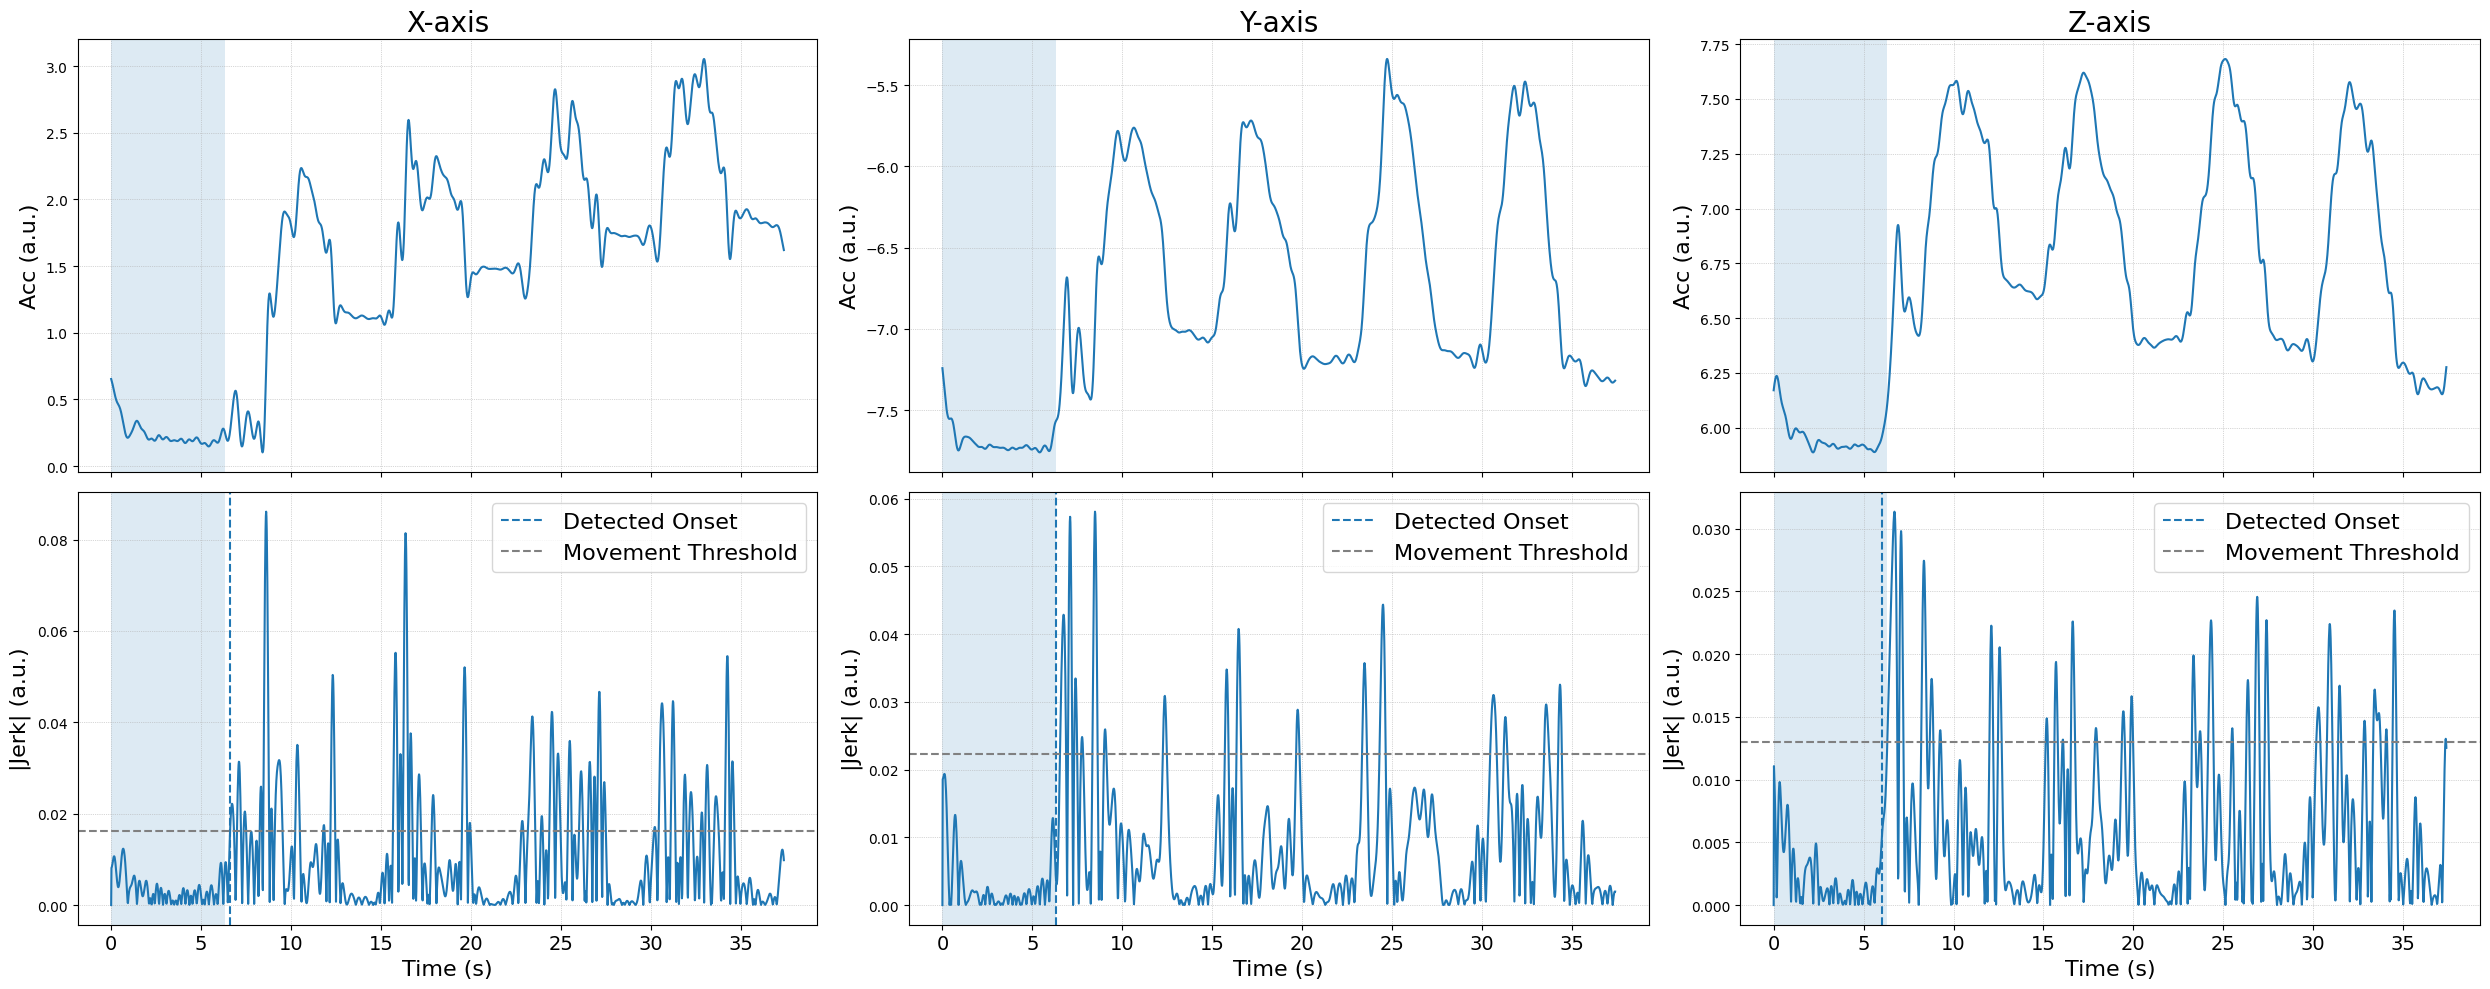

In [60]:
fs = 60.0  # Hz

fig, axs = plt.subplots(
    2, 3,
    figsize=(25, 10),  # good size for IEEE two-column figure*
    sharex=True
)

title_fontsize = 20
label_fontsize = 16
legend_fontsize = 16
tick_fontsize = 14
axes_info = [
    ("X", jx, jx_st, thr_x, "X-axis"),
    ("Y", jy, jy_st, thr_y, "Y-axis"),
    ("Z", jz, jz_st, thr_z, "Z-axis"),
]

for col, (axis_label, jerk, onset, thr, title) in enumerate(axes_info):
    # ---------- ACCELERATION (TOP ROW) ----------
    acc = np.array(df_filt[f'Acc_{axis_label}_{sens_name}'])
    t_acc = np.arange(len(acc)) / fs

    ax_acc = axs[0, col]
    ax_acc.plot(t_acc, acc)
    ax_acc.set_title(title, fontsize=title_fontsize)
    ax_acc.set_ylabel("Acc (a.u.)", size=label_fontsize)

    # Shade cut region from t=0 to global onset (mean_start_loc)
    if not np.isnan(mean_start_loc) and mean_start_loc > 0:
        cut_t = mean_start_loc / fs
        ax_acc.axvspan(0, cut_t, alpha=0.15)

    ax_acc.grid(True, which="both", linestyle=":", linewidth=0.5)

    # ---------- JERK MAGNITUDE (BOTTOM ROW) ----------
    jerk = np.asarray(jerk)
    activity = np.abs(jerk)  # what the algorithm uses
    t_jerk = np.arange(len(activity)) / fs

    ax_jerk = axs[1, col]
    ax_jerk.plot(t_jerk, activity)
    ax_jerk.set_ylabel("|Jerk| (a.u.)", size=label_fontsize)

    # Shade cut region on jerk as well (full height)
    if not np.isnan(mean_start_loc) and mean_start_loc > 0:
        cut_t = mean_start_loc / fs
        ax_jerk.axvspan(0, cut_t, alpha=0.15)

    # Vertical dashed line at axis-specific onset (jerk only)
    if onset is not None and not np.isnan(onset):
        ax_jerk.axvline(
            onset / fs,
            linestyle="--",
            linewidth=1.5,
            label="Detected Onset" # legend only from first column
        )

    # Horizontal dashed threshold line (light grey, jerk only)
    if thr is not None and not np.isnan(thr):
        ax_jerk.axhline(
            thr,
            linestyle="--",
            linewidth=1.5,
            color="grey",
            label="Movement Threshold"  # legend only from first column
        )

    ax_jerk.grid(True, which="both", linestyle=":", linewidth=0.5)
    # Legend for onset + threshold (from first jerk axis)
    ax_jerk.legend(loc="upper right", fontsize=legend_fontsize)
# X label only on bottom row
for col in range(3):
    axs[1, col].set_xlabel("Time (s)", size=label_fontsize)

for ax in axs.ravel():
    ax.tick_params(axis="x", labelsize=tick_fontsize)

plt.tight_layout()
plt.show()


In [28]:
def plot_onset_detected(df_filt, sens_name, jx, jy, jz, jx_st, jy_st, jz_st, title=None):
    fig, axs = plt.subplots(3, 3, figsize=(20,10))
    mean_start_loc = int(np.nanmean([jx_st, jy_st, jz_st]))
    axs[0,0].plot(df_filt[f'Acc_X_{sens_name}'])
    axs[0,1].plot(jx)
    axs[0,2].plot(np.abs(jx))
    axs[0,0].plot(mean_start_loc, np.array(df_filt[f'Acc_X_{sens_name}'])[mean_start_loc], marker='s')
    if np.isnan(jx_st) == False:
        axs[0,0].plot(jx_st, np.array(df_filt[f'Acc_X_{sens_name}'])[jx_st], marker='o', linestyle='')
        axs[0,2].plot(jx_st, np.abs(jx)[jx_st], marker='o', linestyle='')


    axs[1, 0].plot(df_filt[f'Acc_Y_{sens_name}'])

    axs[1, 1].plot(jy)
    axs[1, 2].plot(np.abs(jy))
    axs[1, 0].plot(mean_start_loc, np.array(df_filt[f'Acc_Y_{sens_name}'])[mean_start_loc], marker='s')
    if np.isnan(jy_st) == False:
        axs[1, 0].plot(jy_st, np.array(df_filt[f'Acc_Y_{sens_name}'])[jy_st], marker='o', linestyle='')
        axs[1, 2].plot(jy_st, np.abs(jy)[jy_st], marker='o', linestyle='')

    axs[2, 0].plot(df_filt[f'Acc_Z_{sens_name}'])

    axs[2, 1].plot(jz)
    axs[2, 2].plot(np.abs(jz))
    axs[2, 0].plot(mean_start_loc, np.array(df_filt[f'Acc_Z_{sens_name}'])[mean_start_loc], marker='s')
    if np.isnan(jz_st) == False:
        axs[2, 0].plot(jz_st, np.array(df_filt[f'Acc_Z_{sens_name}'])[jz_st], marker='o', linestyle='') 
        axs[2, 2].plot(jz_st, np.abs(jz)[jz_st], marker='o', linestyle='')
    if title:
        plt.suptitle(title)

def aling_to_movement_onset(df_filt, plot = False, metadata=['P02', 'cup-placing', 'natural']):
        
    sens_name = 'wrist_r'
    jx = jerk_axis(df_filt, sens_name, "X", fs=60)
    jy = jerk_axis(df_filt, sens_name, "Y", fs=60)
    jz = jerk_axis(df_filt, sens_name, "Z", fs=60)
    jx_st = detect_movement_start_from_jerk(jx, baseline_samples=240)
    jy_st = detect_movement_start_from_jerk(jy, baseline_samples=240)
    jz_st = detect_movement_start_from_jerk(jz,  baseline_samples=240)

    # Note: there might be some cases when we don't detect start and stop from wrist
    if np.isnan(jx_st) and np.isnan(jy_st) and np.isnan(jz_st):
        # Enter here only for few condtions
        print('No onset detected here, cutting ...')
        sens_name = 'wrist_l'
        jx = jerk_axis(df_filt, sens_name, "X", fs=60)
        jy = jerk_axis(df_filt, sens_name, "Y", fs=60)
        jz = jerk_axis(df_filt, sens_name, "Z", fs=60)
        jx_st = detect_movement_start_from_jerk(jx, baseline_samples=240)
        jy_st = detect_movement_start_from_jerk(jy, baseline_samples=240)
        jz_st = detect_movement_start_from_jerk(jz,  baseline_samples=240)

        plot = True
    
    # for simplicty, take the mean
    mean_start_loc = int(np.nanmean([jx_st, jy_st, jz_st]))
    if plot:
        plot_onset_detected(df_filt, sens_name, jx, jy, jz, jx_st, jy_st, jz_st, title=f"{metadata[0]} - {metadata[1]} - {metadata[2]} - {sens_name}")

    df_filt_cut = df_filt.iloc[mean_start_loc:].copy()
    return df_filt_cut


Done with: P02 - cup-placing - natural
Done with: P02 - cup-placing - elbow_wrist_brace
Done with: P02 - cup-placing - elbow_brace
Done with: P02 - peg - natural
Done with: P02 - peg - elbow_wrist_brace
Done with: P02 - peg - elbow_brace
Done with: P02 - pouring - natural
Done with: P02 - pouring - elbow_wrist_brace
Done with: P02 - pouring - elbow_brace
Done with: P02 - wiping - natural
reached end without data found
reached end without data found
reached end without data found
No onset detected here, cutting ...
reached end without data found
reached end without data found
Done with: P02 - wiping - elbow_wrist_brace
Done with: P02 - wiping - elbow_brace
Done with: P03 - cup-placing - natural
Done with: P03 - cup-placing - elbow_wrist_brace
Done with: P03 - cup-placing - elbow_brace
Done with: P03 - peg - natural
Done with: P03 - peg - elbow_wrist_brace
Done with: P03 - peg - elbow_brace
Done with: P03 - pouring - natural
Done with: P03 - pouring - elbow_wrist_brace
Done with: P03 - p

KeyboardInterrupt: 

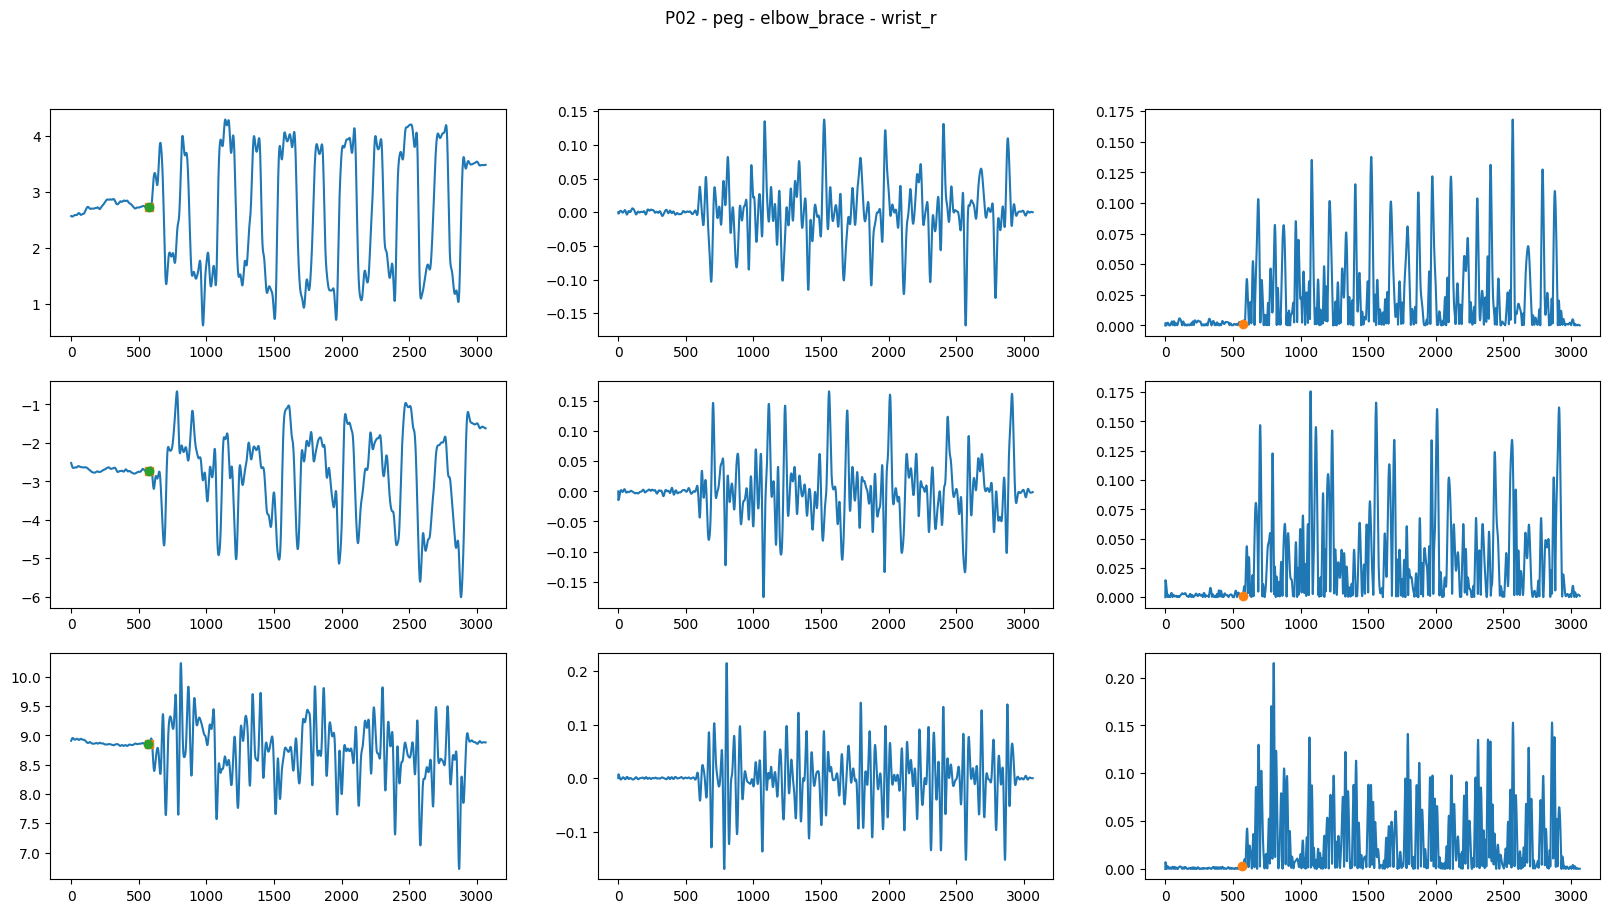

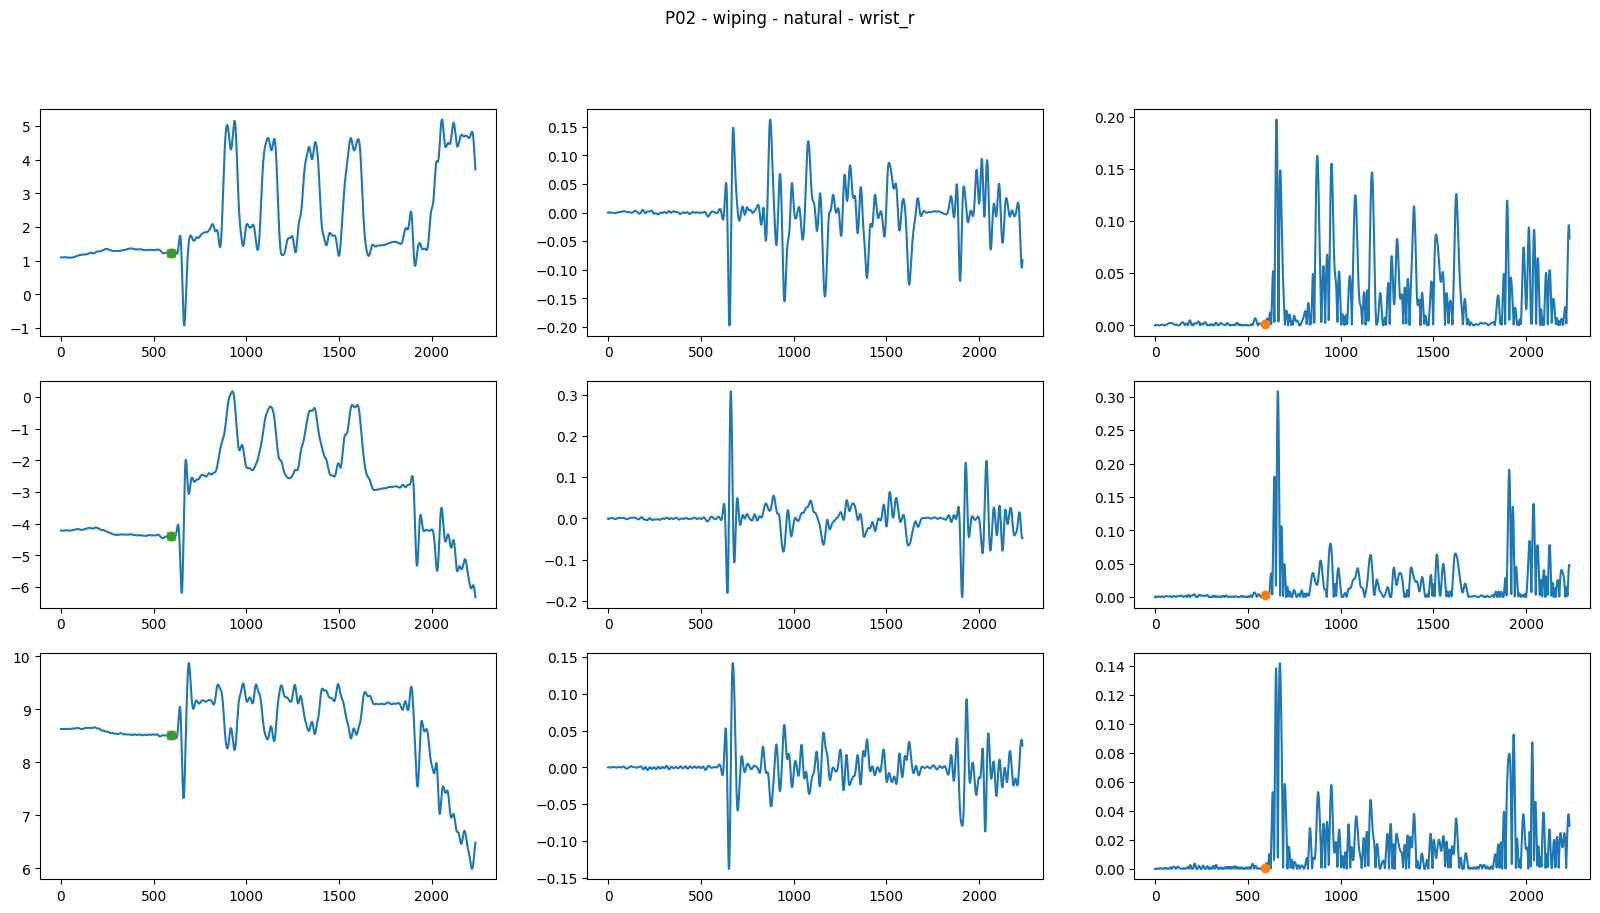

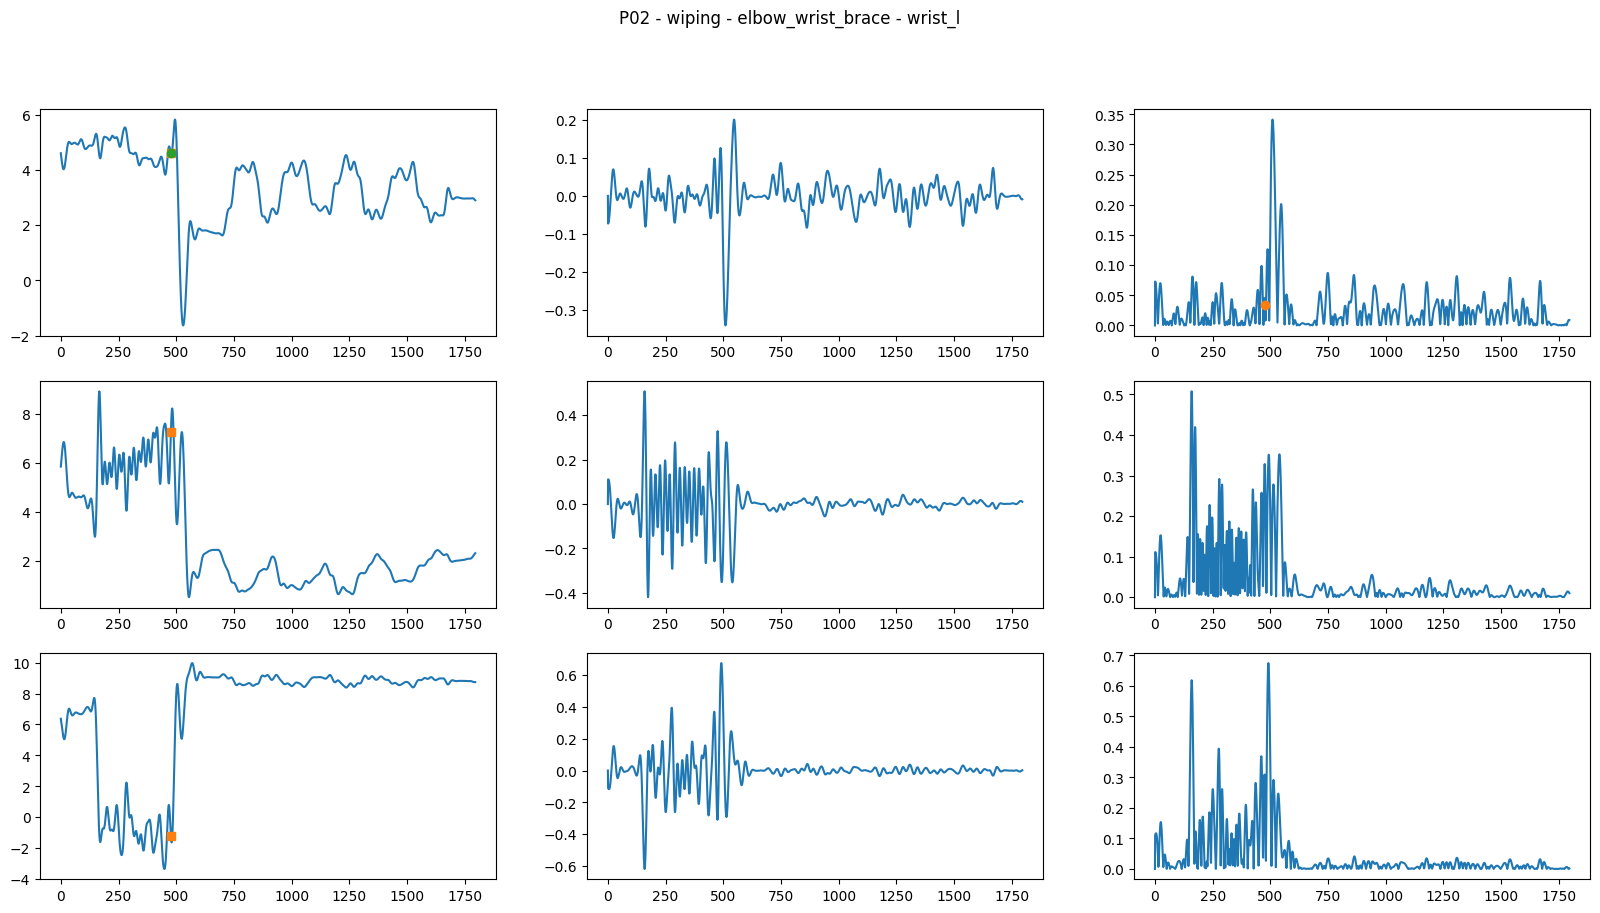

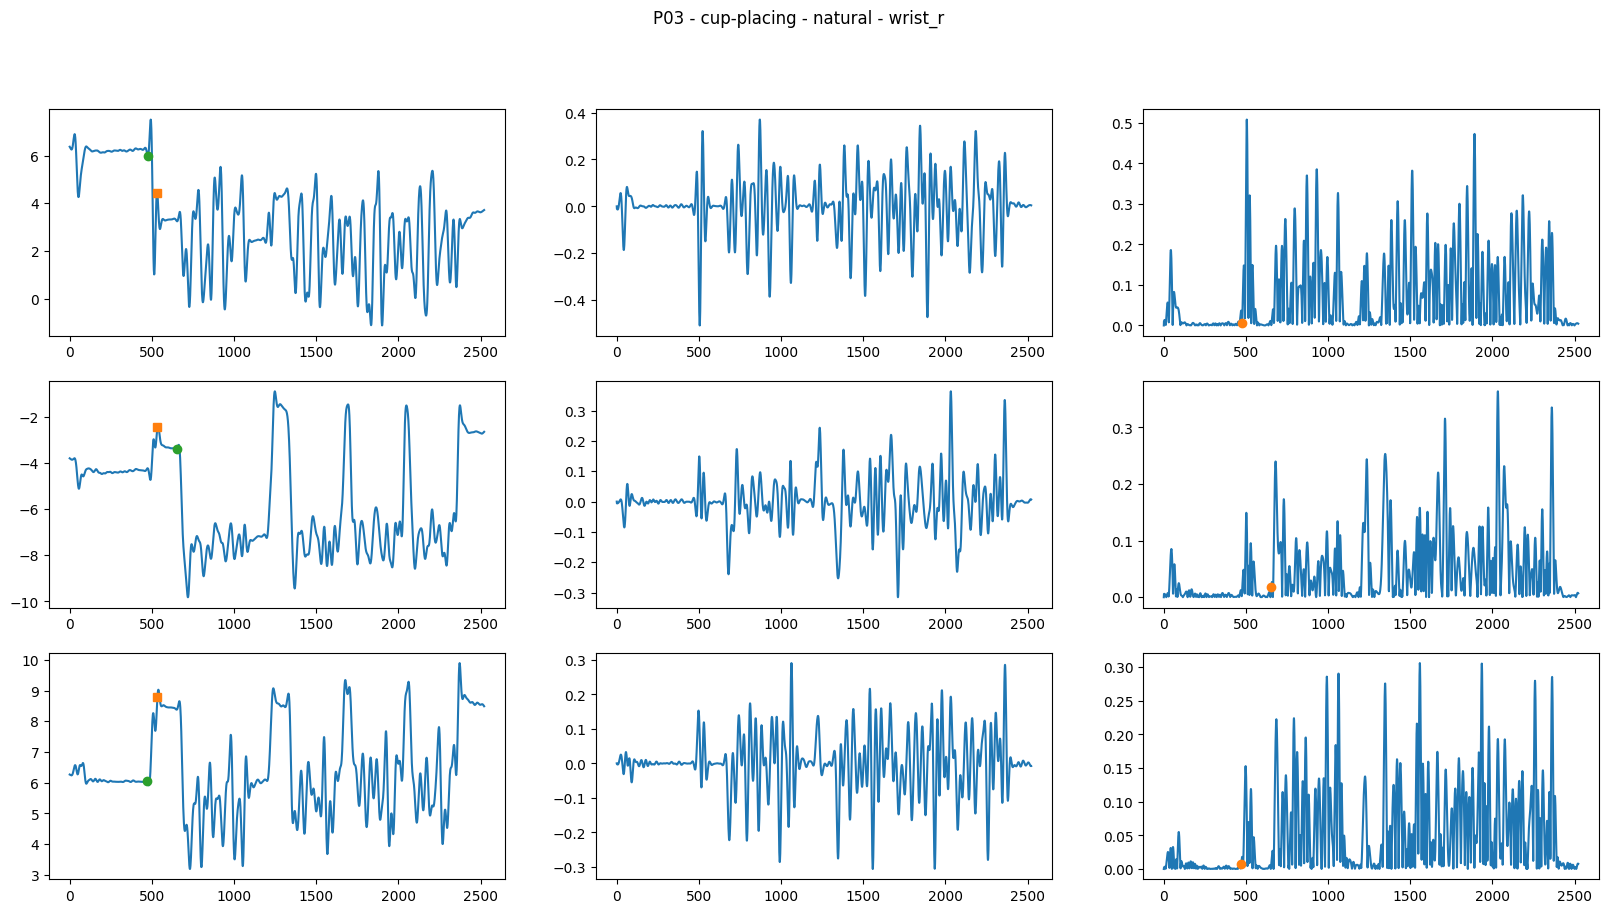

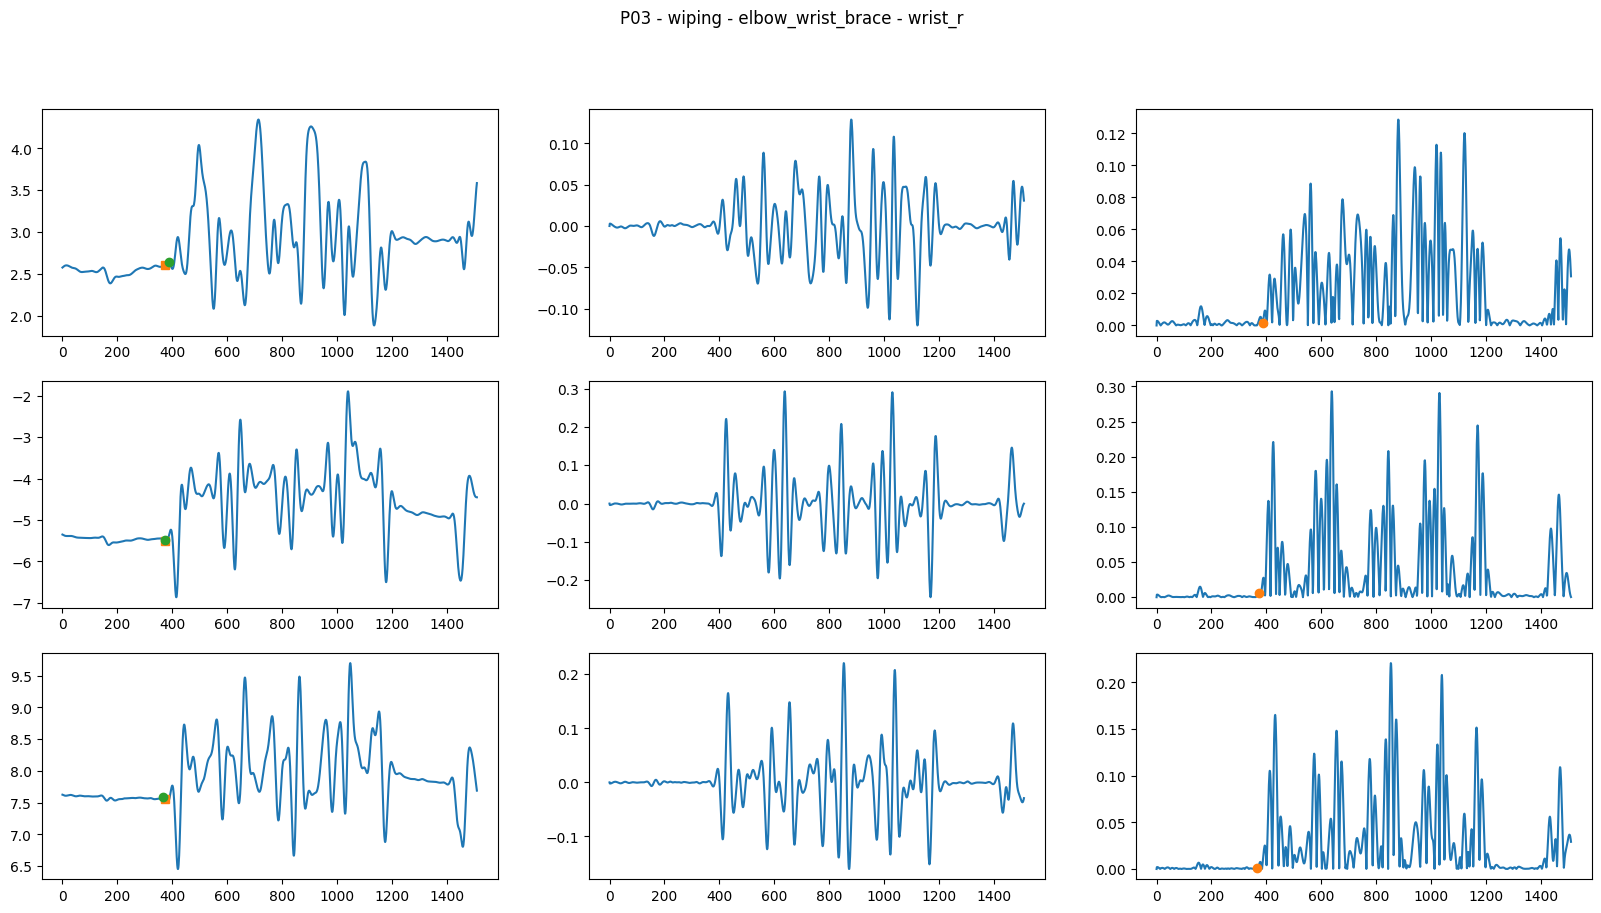

In [29]:
import random
all_subjects_preproc = []

n_total = len(all_subjects)
n_to_plot = min(10, n_total)

# pick 10 random indices to plot
idxs_to_plot = set(random.sample(range(n_total), n_to_plot))

for idx, item in enumerate(all_subjects):
    df_raw = item['data']

    # Apply filtering 
    df_filt = filter_butterworth(df_raw, fs=60, cutoff=2)

    # For 10 random items, enable plotting inside aling_to_movement_onset
    do_plot = idx in idxs_to_plot
    df_cut = aling_to_movement_onset(df_filt, plot=do_plot, metadata=[item['subject'], item['task'], item['condition']])

    all_subjects_preproc.append({
        "subject": item['subject'],
        "task": item['task'],
        "condition": item['condition'],
        "data": df_cut,
    })
    print(f"Done with: {item['subject']} - {item['task']} - {item['condition']}")

In [ ]:
sensors

{'arm_l', 'arm_r', 'trunk', 'wrist_l', 'wrist_r'}

In [ ]:
df_for_feat = all_subjects_preproc[50]['data'].copy()

In [ ]:
def feat_jerk(x, fs = int(60)):
    """
    Smoothness: jerk = derivative of signal (approx).
    Using finite difference: jerk = dx/dt.
    Report RMS jerk.
    """
    if len(x) < 2:
        return 0      
    dx = np.diff(x)
    jerk = dx * fs
    return np.sqrt(np.mean(jerk**2))

def extract_features_from_signal(df, col, fs):
    x = df[col].to_numpy()
    #t = df["timestamp"].to_numpy()

    return {
        f"{col}_MAX": feat_max(x),
        f"{col}_MIN": feat_min(x),
        f"{col}_AMP": feat_amp(x),
        f"{col}_MEAN": feat_mean(x),
        f"{col}_JERK": feat_jerk(x, fs=60),
        f"{col}_RMS": feat_rms(x),
        f"{col}_COR": feat_corr(x),
        f"{col}_STD": feat_std(x),
    }

import pandas as pd
import numpy as np

def extract_all_features(
    df,
    exclude_acc=False,
    exclude_quat=False,
    exclude_gyro=False,
    exclude_mag=False,
    window_ms=None,
    fs=60,
):
    """
    Returns a DataFrame with features from all XSens signals
    (Acc, Quat, Gyr, Mag).

    - If window_ms is None: single-row DataFrame with features over entire df.
    - If window_ms is not None: one row per window, indexed by window start
      time (value from df.index).

    Assumes df.index is a regular time axis with step 1/fs.
    """

    def _feature_columns(df_win):
        quaternion_columns = (
            df_win.columns[df_win.columns.str.contains("Quat")]
            if not exclude_quat else []
        )
        acc_columns = (
            df_win.columns[df_win.columns.str.contains("Acc")]
            if not exclude_acc else []
        )
        gyr_columns = (
            df_win.columns[df_win.columns.str.contains("Gyr")]
            if not exclude_gyro else []
        )
        mag_columns = (
            df_win.columns[df_win.columns.str.contains("Mag")]
            if not exclude_mag else []
        )

        return (
            list(quaternion_columns)
            + list(acc_columns)
            + list(gyr_columns)
            + list(mag_columns)
        )

    # ---------- no windowing: one feature vector ----------
    if window_ms is None:
        feature_columns = _feature_columns(df)
        feats = {}
        for col in feature_columns:
            if col not in df.columns:
                continue
            feats.update(extract_features_from_signal(df, col, fs=fs))

        # index = first time sample of this segment
        idx0 = df.index[0] if len(df.index) > 0 else 0
        return pd.DataFrame([feats], index=[idx0])

    # ---------- windowed version (sample-based, index is numeric time) ----------
    # window length in samples
    win_samples = int(round(window_ms * fs / 1000.0))
    if win_samples < 1:
        raise ValueError("window_ms too small for given fs.")

    n = len(df)
    rows = []
    idxs = []

    # non-overlapping windows: 0..win, win..2win, ...
    for start in range(0, n - win_samples + 1, win_samples):
        stop = start + win_samples
        df_win = df.iloc[start:stop]

        if df_win.empty:
            continue

        feature_columns = _feature_columns(df_win)
        feats = {}
        for col in feature_columns:
            if col not in df_win.columns:
                continue
            feats.update(extract_features_from_signal(df_win, col, fs=fs))

        rows.append(feats)
        # use df.index as "time" for this window (start of window)
        idxs.append(df_win.index[0])

    return pd.DataFrame(rows, index=idxs)


In [ ]:
exclude_quat = False
exclude_acc = False
exclude_gyro = False
exclude_mag = False
WINDOW_SIZE_MS = 500

import random
all_subjects_preproc = []

n_total = len(all_subjects)
n_to_plot = min(10, n_total)

# pick 10 random indices to plot
idxs_to_plot = set(random.sample(range(n_total), n_to_plot))

for idx, item in enumerate(all_subjects):
    df_raw = item['data']

    # Apply filtering 
    df_filt = filter_butterworth(df_raw, fs=60, cutoff=2)

    # For 10 random items, enable plotting inside aling_to_movement_onset
    do_plot = idx in idxs_to_plot
    df_cut = aling_to_movement_onset(df_filt, plot=do_plot, metadata=[item['subject'], item['task'], item['condition']])

    df_feat = extract_all_features(df_for_feat, window_ms=WINDOW_SIZE_MS)
    df_feat['task'] = item['task']
    df_feat['condition'] = item['condition']

    all_subjects_preproc.append({
        "subject": item['subject'],
        "task": item['task'],
        "condition": item['condition'],
        "data": df_cut,
        'features' : df_feat, 
    })
    print(f"Done with: {item['subject']} - {item['task']} - {item['condition']}")



NameError: name 'feat_max' is not defined

In [ ]:
import pandas as pd

# Collect all feature rows into one big dataframe
feat_rows = []

for item in all_subjects_preproc:
    df_feat = item["features"].copy()

    # Make sure subject/task/condition are present as columns
    df_feat["subject"] = item["subject"]
    df_feat["task"] = item["task"]
    df_feat["condition"] = item["condition"]

    feat_rows.append(df_feat)

# Concatenate all subjects
all_feats = pd.concat(feat_rows, axis=0)


# Save to CSV
all_feats.to_csv(f"features_win_{WINDOW_SIZE_MS}.csv", index=True)  # index=True keeps the time / window index
print("Saved features to all_subjects_preproc.csv")


Saved features to all_subjects_preproc.csv


In [ ]:
save_path = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\imu_compensatory_movements\Data\Features"
all_feats.to_csv(save_path+f"/features_win_{WINDOW_SIZE_MS}.csv", index=True)  # index=True keeps the time / window index

# Example on How to use

In [ ]:
tasks_conditions

{('cup-placing', 'elbow_brace'),
 ('cup-placing', 'elbow_wrist_brace'),
 ('cup-placing', 'natural'),
 ('peg', 'elbow_brace'),
 ('peg', 'elbow_wrist_brace'),
 ('peg', 'natural'),
 ('pouring', 'elbow_brace'),
 ('pouring', 'elbow_wrist_brace'),
 ('pouring', 'natural'),
 ('wiping', 'elbow_brace'),
 ('wiping', 'elbow_wrist_brace'),
 ('wiping', 'natural'),
 (None, None)}

In [ ]:

feats_all = pd.read_csv(r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\imu_compensatory_movements\Data\Features\features_win_500.csv")
# select one subject

subj_feat = feats_all[feats_all['subject'] == 'P02']
# to select a specific task
subj_task = subj_feat[subj_feat['task'] == 'cup-placing']
subj_task

,Unnamed: 0,Quat_W_arm_l_MAX,Quat_W_arm_l_MIN,Quat_W_arm_l_AMP,Quat_W_arm_l_MEAN,Quat_W_arm_l_JERK,Quat_W_arm_l_RMS,Quat_W_arm_l_COR,Quat_W_arm_l_STD,Quat_X_arm_l_MAX,...,Mag_Z_wrist_r_MIN,Mag_Z_wrist_r_AMP,Mag_Z_wrist_r_MEAN,Mag_Z_wrist_r_JERK,Mag_Z_wrist_r_RMS,Mag_Z_wrist_r_COR,Mag_Z_wrist_r_STD,task,condition,subject
144,1132,-0.674502,-0.676350,0.001848,-0.675487,0.009611,0.675487,0.000160,0.000592,0.212628,...,-0.329102,0.008789,-0.323381,0.165348,0.323387,0.002745,0.002114,cup-placing,elbow_wrist_brace,P02
145,1162,-0.675580,-0.676740,0.001159,-0.676405,0.006378,0.676405,0.000102,0.000266,0.212953,...,-0.368164,0.048828,-0.327580,0.309595,0.327723,0.004962,0.009698,cup-placing,elbow_wrist_brace,P02
146,1192,-0.674880,-0.677710,0.002830,-0.676030,0.022260,0.676031,0.000370,0.000772,0.207468,...,-0.571289,0.181885,-0.530729,0.680825,0.532885,0.010123,0.047883,cup-placing,elbow_wrist_brace,P02
147,1222,-0.676556,-0.679251,0.002696,-0.678552,0.011379,0.678553,0.000174,0.000744,0.195503,...,-0.537842,0.012451,-0.531527,0.213024,0.531535,0.003548,0.002883,cup-placing,elbow_wrist_brace,P02
148,1252,-0.678324,-0.680484,0.002160,-0.679420,0.012517,0.679420,0.000208,0.000604,0.202180,...,-0.750977,0.217285,-0.633545,0.570226,0.638874,0.005879,0.082347,cup-placing,elbow_wrist_brace,P02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2422,-0.666407,-0.667882,0.001475,-0.667094,0.009224,0.667095,0.000149,0.000360,0.234715,...,-0.324951,0.010986,-0.318644,0.250268,0.318659,0.004166,0.003049,cup-placing,natural,P02
284,2452,-0.666203,-0.666980,0.000778,-0.666574,0.004255,0.666574,0.000071,0.000271,0.233289,...,-0.327881,0.011963,-0.319645,0.209434,0.319654,0.003490,0.002413,cup-placing,natural,P02
285,2482,-0.665036,-0.726127,0.061091,-0.683909,0.212145,0.684291,0.002965,0.022847,0.252904,...,-0.364746,0.052002,-0.323315,0.278453,0.323516,0.004353,0.011392,cup-placing,natural,P02
286,2512,-0.596851,-0.721591,0.124740,-0.632661,0.374344,0.634050,0.004519,0.041951,0.182184,...,-0.408447,0.076660,-0.365405,0.344612,0.366532,0.005603,0.028723,cup-placing,natural,P02


# For Additional Understanding: Inspecting Timestamps

In [ ]:
import numpy as np

In [ ]:
# take one df as example
df_sample = data[0]['dataframe']
df_sample


,PacketCounter,SampleTimeFine,Quat_W,Quat_X,Quat_Y,Quat_Z,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z,Mag_X,Mag_Y,Mag_Z
0,0,1970-01-01 21:07:25,-0.736210,0.183717,0.638716,0.127616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.262207,0.231201,-0.031738
1,1,1970-01-02 01:45:12,-0.736222,0.183720,0.638712,0.127565,9.708877,-1.067807,1.129502,-1.429176,0.690589,0.529434,-0.262695,0.232666,-0.031250
2,2,1970-01-02 06:22:59,-0.736170,0.183847,0.638716,0.127661,9.700046,-1.093796,1.111337,-1.696598,0.339913,0.393840,-0.263672,0.232178,-0.031250
3,3,1970-01-02 11:00:46,-0.736107,0.183970,0.638727,0.127792,9.719351,-1.097965,1.145534,-1.721801,0.291210,0.197749,-0.262207,0.233643,-0.032959
4,4,1970-01-02 15:38:33,-0.736076,0.183974,0.638764,0.127781,9.745931,-1.099311,1.121240,-1.277600,0.308383,0.286817,-0.260254,0.232666,-0.030273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,3408,1971-10-21 07:13:01,-0.719578,0.178472,0.651305,0.161739,9.886127,-0.437688,0.917514,3.813366,-2.382762,0.010354,-0.249512,0.196533,-0.023682
3409,3409,1971-10-21 11:50:48,-0.719438,0.178067,0.651667,0.161349,9.884576,-0.412174,0.947209,3.465393,-1.875055,-0.099915,-0.248779,0.198975,-0.023682
3410,3410,1971-10-21 16:28:35,-0.719289,0.177722,0.652004,0.161029,9.871667,-0.349122,0.928267,2.811551,-1.771682,-0.164408,-0.249023,0.198975,-0.023193
3411,3411,1971-10-21 21:06:22,-0.719175,0.177484,0.652258,0.160773,9.916303,-0.301401,0.893422,1.946700,-1.241627,0.143578,-0.248047,0.200928,-0.023193


In [ ]:
# SampleTimeFine is not a real time
# It's a value coming from the Internal Device Clock (1 MHz clock)
# This clock is re-set every time a new acquistion start

# The unit of the timestamp (SampleTimeFine) is μs (microsecond). 
# This value reset to 0 when the sensor is restarted, and it wraps at 4294967295 (232 − 1), which is about 1.2 hours after the sensor restarts.

# See: https://base.movella.com/s/question/0D5Tc000007iUoBKAU/about-sampletimefine?language=en_US

In [ ]:
# convert timestamps to datetime
ts = pd.to_datetime(df_sample["SampleTimeFine"])
# difference between consecutive timestamps
dt = ts.diff().dt.total_seconds()           # Note: this in reality is "microseconds"

In [ ]:
# Why
unique_dt = dt.iloc[1:].unique()
print('Got unique dt:', unique_dt)
# Our IMU samples at 60 Hz
expected_dt_us = (1/60) * (10**6)
expected_dt_us = np.round(expected_dt_us, 0).astype(int)
print('Expected dt:', expected_dt_us)

Got unique dt: [16667.]
Expected dt: 16667


In [ ]:
dfs_sensors[2]['SampleTimeFine']

0       1970-01-01 21:35:42
1       1970-01-02 02:13:29
2       1970-01-02 06:51:16
3       1970-01-02 11:29:03
4       1970-01-02 16:06:50
               ...         
2689    1971-06-04 14:55:05
2690    1971-06-04 19:32:52
2691    1971-06-05 00:10:39
2692    1971-06-05 04:48:26
2693    1971-06-05 09:26:13
Name: SampleTimeFine, Length: 2694, dtype: object

In [ ]:
dfs_sensors[3]['SampleTimeFine']

0       1970-01-01 16:57:55
1       1970-01-01 21:35:42
2       1970-01-02 02:13:29
3       1970-01-02 06:51:16
4       1970-01-02 11:29:03
               ...         
2691    1971-06-04 19:32:52
2692    1971-06-05 00:10:39
2693    1971-06-05 04:48:26
2694    1971-06-05 09:26:13
2695    1971-06-05 14:04:00
Name: SampleTimeFine, Length: 2696, dtype: object

In [ ]:
subject_counts = Counter([d['subject'] for d in data])
print("Files per subject:", subject_counts)

# Check unique sensors
sensors = set([d['sensor'] for d in data])
print("Unique sensors:", sensors)

# Check unique task codes
tasks_conditions = set([(d['task'], d['condition']) for d in data])
print("Unique task/condition combinations:", tasks_conditions)


for sample in data:
    sample['dataframe'] = flt.add_timestamp_column(sample['dataframe'], fs=60)

print(f"Applied timestamp column to {len(data)} dataframes")

# ----------------------------------------------------------------------------------
# Feature extraction
# ----------------------------------------------------------------------------------


for sample in data:
    df_raw = sample['dataframe']

    # 1) Moving average version
    df_ma = flt.filter_moving_average(df_raw, n=5)
    sample['df_ma'] = df_ma

    # 2) Full recommended processing pipeline
    df_proc = flt.filter_butterworth(df_raw, fs=60)
    sample['df_butterworth'] = df_proc

# choose one filtering approach
use_pipeline = "df_butterworth"   # OR "df_ma"

feature_rows = []
for sample in tqdm(data, desc="Extracting features"):
    
    df = sample[use_pipeline] 
    
    f = feat.extract_all_features(df)

    # metadata
    subj = sample.get("subject", None)
    task = sample.get("task", None)
    sensor = sample.get("sensor", None)
    cond = sample.get("condition", None)

    # automatic label based on condition
    if cond is not None and str(cond).lower() == "natural":
        label = "normal"
    else:
        label = "compensatory"

    # add metadata columns
    f["subject"] = subj
    f["task"] = task
    f["condition"] = cond
    f["label"] = label
    f["sensor"] = sensor

    feature_rows.append(f)

features_df = pd.concat(feature_rows, ignore_index=True)

Files per subject: Counter({'P03': 65, 'P04': 65, 'P05': 65, 'P06': 65, 'P02': 64})
Unique sensors: {'trunk', 'arm_r', 'arm_l', 'wrist_l', 'wrist_r'}
Unique task/condition combinations: {('pouring', 'elbow_brace'), ('wiping', 'elbow_wrist_brace'), ('pouring', 'natural'), (None, None), ('cup-placing', 'elbow_brace'), ('pouring', 'elbow_wrist_brace'), ('peg', 'elbow_brace'), ('cup-placing', 'natural'), ('cup-placing', 'elbow_wrist_brace'), ('peg', 'natural'), ('wiping', 'elbow_brace'), ('peg', 'elbow_wrist_brace'), ('wiping', 'natural')}
Applied timestamp column to 324 dataframes


KeyboardInterrupt: 

In [ ]:
features_df

,Acc_X_MAX,Acc_X_MIN,Acc_X_AMP,Acc_X_MEAN,Acc_X_JERK,Acc_X_RMS,Acc_X_COR,Acc_X_STD,Acc_Y_MAX,Acc_Y_MIN,...,Roll_MEAN,Roll_JERK,Roll_RMS,Roll_COR,Roll_STD,subject,task,condition,label,sensor
0,10.344648,8.265244,2.079404,9.744119,2.991508,9.745053,0.049858,0.134954,1.200021,-4.458023,...,-0.555794,0.396745,0.562700,0.006612,0.087892,P02,cup-placing,natural,normal,arm_l
1,10.655586,8.307964,2.347622,9.743792,4.745902,9.746107,0.079098,0.212393,1.525704,-4.470877,...,-0.401543,0.647991,0.443928,0.010798,0.189301,P02,pouring,natural,normal,arm_l
2,10.431677,8.661552,1.770125,9.803683,2.830633,9.804512,0.047177,0.127508,0.803545,-3.371943,...,-0.169010,0.479109,0.248262,0.007985,0.181850,P02,peg,natural,normal,arm_l
3,11.335232,6.158304,5.176928,8.878259,4.640279,8.941541,0.077333,1.061916,5.744984,-2.287051,...,0.505317,0.843038,0.606354,0.014050,0.335142,P02,wiping,natural,normal,arm_l
4,10.399370,8.351337,2.048033,9.607250,3.357634,9.609468,0.055961,0.206445,1.115166,-3.946773,...,-0.441902,0.624026,0.523831,0.010399,0.281286,P02,cup-placing,elbow_brace,compensatory,arm_l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,4.682933,-0.781675,5.464608,1.610060,3.754338,1.954922,0.062523,1.108794,-3.441930,-7.618114,...,-0.567381,0.121084,0.577573,0.002017,0.108026,P06,wiping,elbow_brace,compensatory,wrist_r
320,2.087663,-4.646558,6.734221,-0.322611,5.637489,0.781309,0.093958,0.711593,-0.310605,-10.864180,...,-0.678453,0.440269,0.712007,0.007338,0.216000,P06,cup-placing,elbow_wrist_brace,compensatory,wrist_r
321,2.862625,-3.120179,5.982804,-1.100479,5.557855,1.410960,0.092624,0.883036,3.322958,-12.007955,...,-0.404039,0.916954,0.531380,0.015282,0.345134,P06,pouring,elbow_wrist_brace,compensatory,wrist_r
322,1.808017,-3.862672,5.670689,-1.159962,6.271872,1.667586,0.104531,1.198053,-0.290100,-9.129012,...,-0.471947,0.668612,0.520957,0.011143,0.220594,P06,peg,elbow_wrist_brace,compensatory,wrist_r
